<a target="_blank" href="https://colab.research.google.com/github/BrunoCapron/EQE358-metodos_numericos/blob/main/Capitulo_7_Res_EDOs/Notebooks_Códigos/Algoritmos_Adaptativos_RK45.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Método de Runge-Kutta-Fehlberg (RK45) com Passo Adaptativo

Neste notebook, vamos explorar o método RK45, uma variação do método de Runge-Kutta que implementa **controle adaptativo do tamanho do passo**, baseado em uma estimativa de erro local.

### Ideia Principal

- O método RK45 calcula **duas aproximações**: uma de 4ª ordem e outra de 5ª ordem.
- A **diferença entre essas duas soluções** serve como estimativa de erro local.
- Se o erro estiver **acima de uma tolerância definida**, o passo é **reduzido**.
- Se o erro for **muito pequeno**, o passo é **aumentado** para maior eficiência.


## 🌍 Motivação

Ao resolver uma EDO da forma:

$
\frac{dy}{dt} = f(t, y), \quad y(t_0) = y_0
$

não temos, em geral, uma solução analítica. Os métodos numéricos aproximam a solução em uma sequência de pontos $ t_0, t_1, t_2, \dots $, utilizando a derivada para prever o próximo valor de $ y $.

O método de **Runge-Kutta de 4ª ordem (RK4)** é uma dessas técnicas clássicas, com alta precisão para passo fixo. No entanto, em regiões onde a solução muda rapidamente ou lentamente, **usar o mesmo tamanho de passo \( h \)** pode ser ineficiente ou impreciso.

---

## 💡 Ideia do RK45 (Runge-Kutta-Fehlberg)

O RK45 resolve esse problema com um **passo adaptativo**, ou seja, ajusta o tamanho do passo durante a simulação. Ele combina duas fórmulas de Runge-Kutta:

- Uma fórmula de **4ª ordem**: menos precisa, mais barata.
- Uma fórmula de **5ª ordem**: mais precisa, usada para estimar o erro.

### ✏️ Como funciona o passo adaptativo?

1. Em cada ponto $ (t, y) $, calculamos **duas aproximações** do próximo valor $ y(t + h) $:
   - $ y_4 $: aproximação de 4ª ordem.
   - $ y_5 $: aproximação de 5ª ordem.
2. Estimamos o erro local:
   $
   \text{erro} = |y_5 - y_4|
   $
3. Se o erro for **aceitável** (menor que uma tolerância $ \epsilon $), aceitamos o passo.
4. O próximo passo $ h_{\text{novo}} $ é ajustado com base no erro:
   $
   h_{\text{novo}} = h \cdot \min\left( \max\left(0.84 \cdot \left( \frac{\epsilon}{\text{erro}} \right)^{1/4}, 0.1 \right), 4.0 \right)
   $

Esse fator 0.84 é empírico, usado para amortecer oscilações no tamanho do passo.

---

## ⚙️ Por que RK45 é eficiente?

- Em **regiões suaves**, ele aumenta o passo e avança rapidamente.
- Em **regiões críticas**, com variações rápidas, ele reduz o passo automaticamente.
- Evita desperdício computacional de usar passo fixo muito pequeno.

---

## 📌 Observação

O método RK45 é o algoritmo base do solver `scipy.integrate.solve_ivp(method='RK45')`, usado em aplicações reais de engenharia, física e biologia.

A seguir, aplicamos o RK45 a um exemplo concreto com visualização passo a passo da adaptação do passo $ h $.



## Exemplo de EDO: $ \frac{dy}{dt} = y \cdot \sin(t) $

Vamos resolver essa equação com condição inicial $ y(0) = 1 $, até $ t = 10 $, utilizando o RK45.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Define a EDO
def f(t, y):
    return y * np.sin(t)

# Passo RK45
def rk45_step(f, t, y, h):
    c = [0, 1/4, 3/8, 12/13, 1, 1/2]
    a = [
        [],
        [1/4],
        [3/32, 9/32],
        [1932/2197, -7200/2197, 7296/2197],
        [439/216, -8, 3680/513, -845/4104],
        [-8/27, 2, -3544/2565, 1859/4104, -11/40]
    ]
    b4 = [25/216, 0, 1408/2565, 2197/4104, -1/5, 0]
    b5 = [16/135, 0, 6656/12825, 28561/56430, -9/50, 2/55]

    k = []
    for i in range(6):
        ti = t + c[i] * h
        yi = y + h * sum(a[i][j] * k[j] for j in range(i)) if i > 0 else y
        k.append(f(ti, yi))

    y4 = y + h * sum(b4[i] * k[i] for i in range(6))
    y5 = y + h * sum(b5[i] * k[i] for i in range(6))
    error = np.abs(y5 - y4)
    return y5, error

# Inicialização
t0, y0 = 0, 1
T = 10
tol = 1e-5
h = 0.5
t = t0
y = y0
t_values = [t]
y_values = [y]
h_values = []

# Integração adaptativa
while t < T:
    if t + h > T:
        h = T - t
    y_next, error = rk45_step(f, t, y, h)
    if error < tol:
        t += h
        y = y_next
        t_values.append(t)
        y_values.append(y)
        h_values.append(h)
    h = h * min(max(0.84 * (tol / error)**0.25, 0.1), 4.0)

# Animação
fig, ax = plt.subplots()
ax.set_xlim(0, T)
ax.set_ylim(min(y_values)*0.9, max(y_values)*1.1)
line, = ax.plot([], [], 'bo-', label='RK45 Adaptativo')
point, = ax.plot([], [], 'ro')
text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
ax.set_title("RK45 com Passo Adaptativo")
ax.set_xlabel("t")
ax.set_ylabel("y(t)")
ax.legend()

def init():
    line.set_data([], [])
    point.set_data([], [])
    text.set_text('')
    return line, point, text

def update(frame):
    line.set_data(t_values[:frame+1], y_values[:frame+1])
    point.set_data([t_values[frame]], [y_values[frame]])
    if frame > 0:
        text.set_text(f"t = {t_values[frame]:.2f}, h = {h_values[frame-1]:.3f}")
    else:
        text.set_text("")
    return line, point, text

ani = FuncAnimation(fig, update, frames=len(t_values),
                    init_func=init, blit=False, interval=300)

# Salvar o GIF
ani.save("rk45_adaptativo.gif", writer=PillowWriter(fps=2))


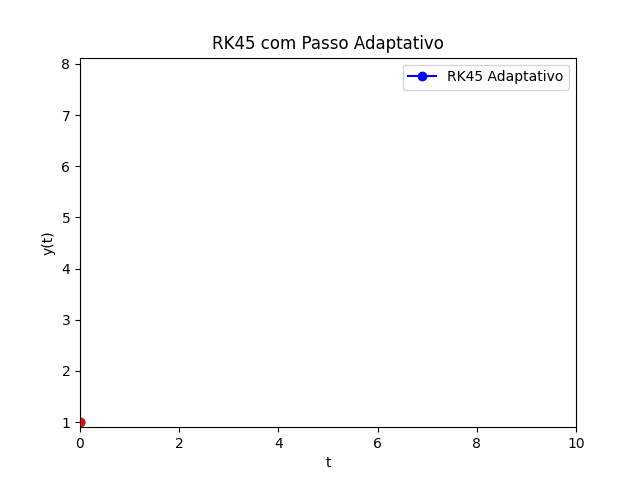

In [8]:
from IPython.display import Image
Image(filename="rk45_adaptativo.gif")



## ✅ Conclusão

O método RK45 é extremamente útil quando queremos resolver EDOs com alta precisão e eficiência computacional. O uso de passos adaptativos evita desperdício de cálculo em regiões onde a solução varia lentamente, e melhora a precisão onde a solução varia rapidamente.
